### Reducing membrane affinity to restore plasma membrane association

Context:
- PAR-2(GCN4) displays strong localisation to internal membranes and reduced plasma membrane association
- Models predict that redicing the membrane affinity of monomers should increase membrane association for PAR-2(GCN4) by increasing membrane exchange kinetics. Conversely, the opposite should be true for PAR-2(wt) as membrane exchange kinetics are not limiting
- We mutate 2 residues in the PRBH domain of PAR-2 to reduce membrane affinity

Results:
- As expected, PRBH mutation reduced membrane affinity of PAR-2(wt), but has a modest _increase_ in affinity for PAR-2(GCN4)

Dependencies:
- Relies on quantification data generated by _Run/par2_nebd_quantify.ipynb_

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import bounded_mean_1d, lighten, load_image, rotated_embryo, raw_data_path, dataplot
import matplotlib.transforms as transforms
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Quantification

In [2]:
# Import data
df = pd.read_csv('../../../data/par2_nebd_embryos.csv')
if raw_data_path:
    df['Path'] = df['Path'].apply(lambda x: raw_data_path + x)
df_quantification = pd.read_csv('../../../data/par2_nebd_quantification.csv')

# Summary quantification
df_quantification_grouped = df_quantification.groupby('EmbryoID')
df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1]) 
    ratio_post = mem_post / cyt
    mem_frac = 0.5 * bounded_mean_1d(r['Membrane signal'], [0.75, 0.25]) / ((cyt / 0.174) + mem_tot)
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_ant': mem_ant, 'Mem_post': mem_post,
        'Ratio post': ratio_post, 'Mem_frac': mem_frac} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Filter
df = df[df.Line.isin(['lp637', 'nwg495', 'nwg489', 'nwg376'])]

# Add genotype column
genotype_dict = {'lp637': 'WT', 'nwg495': 'PRBH', 'nwg489': 'PRBH+GCN4', 'nwg376': 'GCN4'}
df['Genotype'] = [genotype_dict[a] for a in df['Line']]

### Plot: fraction at posterior PM

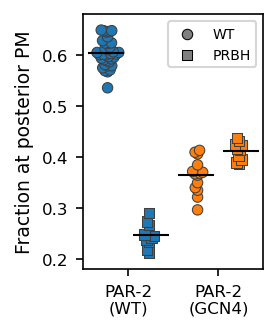

In [3]:
palette1 = {'WT':'tab:blue', 'GCN4':'tab:orange'}
palette2 = {'PRBH':lighten('tab:blue'), 'PRBH+GCN4':lighten('tab:orange')}
palette2 = {'PRBH':'tab:blue', 'PRBH+GCN4':'tab:orange'}

fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData


_df = df[df.Genotype.isin(['WT', 'GCN4'])]
dataplot(data=_df[_df.RNAi == 'wt'], x='Genotype', y='Mem_frac', ax=ax, linewidth=0.5, 
         hue='Genotype', palette=palette1, transform=trans+offset(-10), offset=-0.25,
        order=['WT', 'GCN4'], marker='o')
_df = df[df.Genotype.isin(['PRBH', 'PRBH+GCN4'])]
dataplot(data=_df[_df.RNAi == 'wt'], x='Genotype', y='Mem_frac', ax=ax, linewidth=0.5, 
         hue='Genotype', palette=palette2, transform=trans+offset(10), offset=0.25,
        order=['PRBH', 'PRBH+GCN4'], marker='s')
ax.get_legend().remove()

dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color='tab:gray', s=25)
dot2 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color='tab:gray', s=25, marker='s')
ax.legend([dot1, dot2], ['WT', 'PRBH'], fontsize=6.7, loc='upper right')

ax.set_xticklabels(['PAR-2\n(WT)', 'PAR-2\n(GCN4)'])
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('')
ax.set_ylim(0.18, 0.68)
ax.set_ylabel('Fraction at posterior PM', fontsize=9)
fig.set_size_inches(2, 2.5)
fig.subplots_adjust(left=0.3, bottom=0.2)
fig.savefig('Figs/fraction_prbh.png', dpi=600, transparent=True)

### Images

In [4]:
paths_prbh = df[df.Line == 'nwg495'].Path.to_list()
paths_prbh_gcn4 = df[df.Line == 'nwg489'].Path.to_list()

def panel(path, ax, scale_bar=False):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI_fit.txt')
    rotated = rotated_embryo(img, roi, 220, 160, 3)
    ax.imshow(rotated, cmap='gray', vmin=0, vmax=np.percentile(rotated, 99.9))
    ax.set_xticks([])
    ax.set_yticks([])
    
    if scale_bar:
        px = 0.255 # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot([rotated.shape[1]-10-bar_pixels, rotated.shape[1]-10], [y, y], color='w', linewidth=2)
    
if raw_data_path:
    fig, ax = plt.subplots(2, 1)
    panel(paths_prbh[0], ax[0], scale_bar=True)
    panel(paths_prbh_gcn4[0], ax[1])
    ax[0].set_ylabel('PAR-2(PRBH)', fontsize=10)
    ax[1].set_ylabel('PAR-2\n(GCN4,PRBH)', fontsize=10)
    ax[0].scatter(200, 15, c='tab:blue', s=60, edgecolors='k', marker='s')
    ax[1].scatter(200, 15, c='tab:orange', s=60, edgecolors='k', marker='s')
    fig.set_size_inches(2.5, 3)
    fig.savefig('Figs/imgs_prbh.png', dpi=600, transparent=True)